# Using QCoDeS Drivers for the Keysight M3202A (AWG) and M3102A (Digitizer)
---
### Author: Noah Tajwar (ntajwar@student.ubc.ca)
### Last Updated: 2021-05-31
---

## Background

### Instruments

We currently have a Keysight PXIe Chassis (M9019A) connected to the lab computer (ece-cdw-js01). The following modules are installed in the chassis:
* \[**Slot 1**\] [M9024A: PXIe High Performance System Module](https://www.keysight.com/ca/en/product/M9024A/pxie-high-perf-system-module-connectivity-expansion-dual-port.html)
  * This module connects to the PC which acts as a controller
  * There is an alternative setup where you can put an embedded controller in slot 1 and then you don't need a connection to a PC (we don't have that)
* \[**Slot 3**\] [M3102A: PXIe Digitizer](https://www.keysight.com/ca/en/product/M3102A/pxie-digitizer-500-msa-s-14-bit-200-mhz.html)
  * 500 MSa/s
  * 14-bit
  * 200 MHz
* \[**Slot 4**\] [M3202A: PXIe Arbitrary Waveform Generator (AWG)](https://www.keysight.com/ca/en/product/M3202A/pxie-arbitrary-waveform-generator-1-gsa-s-14-bit-400-mhz.html)
  * 1 GS/s
  * 14-bit
  * 400 MHz

### [QCoDeS](https://qcodes.github.io/)

QCoDeS does not currently have drivers for these Keysight modules in their main repository. However, the repository of third-party contributed drivers ([Qcodes_contrib_drivers](https://github.com/QCoDeS/Qcodes_contrib_drivers)) does have some driver support for these modules:
* M3202A (AWG): Fully functional driver
* M3102A (Digitizer): There is a base-class driver (`SD_DIG`) that seems to partially work but some things are implemented strangely

I've forked the Qcodes_contrib_drivers repo [here](https://github.com/noaht11/Qcodes_contrib_drivers) and fixed `SD_DIG` as well as added a specific driver for the `M3102A` (more on that at the bottom of the notebook). After setting up QCoDeS, install the updated Qcodes_contrib_drivers package:
```
git clone git@github.com:noaht11/Qcodes_contrib_drivers.git
pip install ./Qcodes_contrib_drivers
```

### [Keysight SD1 3.x](https://www.keysight.com/ca/en/lib/software-detail/instrument-firmware-software/sd1-3x-software-3120392.html)

SD1 is the name of the software library provided by Keysight for controlling and interfacing with their PXIe modules (we are using version 3.x). This includes a Python API which is used by the Qcodes_contrib drivers.

There are User's Guides for each of the PXIe modules that have all the necessary information to use the Python API:
* [M3202A (AWG) User's Guide](http://literature.cdn.keysight.com/litweb/pdf/M3XXX-90003.pdf)
* [M3102A (Digitizer) User's Guide](http://literature.cdn.keysight.com/litweb/pdf/M3XXX-90004.pdf)

---

The rest of this notebook includes some examples of how to use the Qcodes drivers to operate the AWG and Digitizer.

Based on the examples provided in the [Qcodes_contrib_drivers examples directory](https://github.com/QCoDeS/Qcodes_contrib_drivers/tree/master/docs/examples).

---

## Basic Imports

In [1]:
import logging

import numpy as np
import matplotlib.pyplot as plt

# The following line causes figures to appear in separate windows
# Comment out to have inline plots in the jupyter notebook

%matplotlib qt

## QCoDeS Setup

Load all the Python modules for using Qcodes.

In [2]:
import qcodes

import qcodes.logger as logger
from qcodes.logger import start_all_logging

# from waveforms import create_sine, create_gaussian, queue_oneshot, trigger_fall
# from digitizer import setup_dig_pxi

start_all_logging()
# logger.get_file_handler().setLevel(logging.DEBUG)

# try to close station from previous run.
try:
    station.close_all_registered_instruments()
except: pass

station = qcodes.Station()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\noah\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\noah\.qcodes\logs\210603-5264-qcodes.log


## Keysight Instrument Setup

Add the Keysight AWG (M3202A) and Digitizer (M3102A) to the QCoDeS station

NOTES:
* The Keysight SD1 Python API may need to be added to the path before it can be loaded. This is done automatically by the script (assuming the API is installed in `C:\Program Files (x86)\Keysight\SD1\Libraries\Python`)
* Make sure you have installed the forked Qcodes_contrib_drivers package (see above) otherwise `Keysight_M3102A` will fail to load
* This assumes the Digitizer is in slot 3 and the AWG is in slot 4, update as required (see the comment in the code)



In [3]:
try:
    import keysightSD1
except:
    import sys
    # Update this path if you have the SD1 library installed somewhere else
    sys.path.append(r"C:\Program Files (x86)\Keysight\SD1\Libraries\Python")
    import keysightSD1

from qcodes_contrib_drivers.drivers.Keysight.M3202A import M3202A # AWG
from qcodes_contrib_drivers.drivers.Keysight.Keysight_M3102A import Keysight_M3102A # Digitizer

# setup station (update the slot numbers if necessary)
awg = M3202A("AWG", chassis = 1, slot = 4)
dig = Keysight_M3102A("DIG", chassis = 1, slot = 3)

station.add_component(awg)
station.add_component(dig)

# turn off AWG to be safe
awg.off()

2021-06-03 17:11:02,414 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 215 ¦ [AWG(M3202A)] Snapshot: Could not update parameter: status
2021-06-03 17:11:02,421 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 215 ¦ [DIG(Keysight_M3102A)] Snapshot: Could not update parameter: status


## Triggering

For all of the examples here, we will be triggering using the **PXIe trigger line 1**, which is a digital signal that connects to both the AWG and Digitizer through the PXIe chassis. This allows us to simultaneously trigger both devices.

NOTES:
* There's two numbering conventions for PXIe triggers. Sometimes PXIe trigger line 1 is referred to just as `1`. Other times it's `4001`. The documentation uses both in different places, but it doesn't always seem to match what the software API accepts. So far I've just figured it out by trial and error.
* The trigger can be generated by calling `set_pxi_trigger` from either the AWG QCoDeS instrument or the Digitizer instrument.
* We are using falling edge triggers for all the examples

In [4]:
# Convenience method to produce a falling edge trigger
def pxi_trigger_fall(instrument, trigger_pxi_line=1):
    instrument.set_pxi_trigger(0, trigger_pxi_line) # 0 = ON
    instrument.set_pxi_trigger(1, trigger_pxi_line) # 1 = OFF

## AWG Operation

The high-level steps of operating the AWG are:

1. Ceaate Python array of discrete samples (with 1 ns or more between samples) representing the waveform
2. Upload waveform to AWG RAM
3. Queue up a sequence of waveforms
4. Set other configurations (triggering / modulation etc.)
5. Start the module

In [5]:
from typing import List

# Default AWG sampling rates
AWG_SAMPLE_RATE_MSPS = 1000 # 1 GS/s

class AWGWaveData:
    def __init__(self, samples, dt_ns = 1):
        self.samples = samples
        self.dt_ns   = dt_ns

        # Identifies a wave that has already been uploaded to the module RAM if not None
        self.num = None

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_title("AWG Wave Data")
            ax.set_xlabel("Time (ns)")
            ax.set_ylabel("Voltage (V)")

        time_domain = np.arange(len(self.samples)) * self.dt_ns
        ax.plot(time_domain, self.samples, label="AWG")

###############################################################################
# AWG HELPER FUNCTIONS
###############################################################################

def awg_get_prescaler(sample_rate_MSps: int = AWG_SAMPLE_RATE_MSPS) -> int:
    """
    Calculate the prescaler for the given sample rate (in MS/s).
    
    See section 1.2.3 of the AWG documentation for details.
    
    The effective sampling rate is calculated as:
    
        1 GS/s              , prescaler == 0
        200 MS/s            , prescaler == 1
        100 MS/s / prescaler, prescaler > 1
    """
    
    if sample_rate_MSps == 1000:
        return 0
    elif sample_rate_MSps == 200:
        return 1
    elif sample_rate_MSps <= 50:
        if 100 % sample_rate_MSps == 0:
            return 100 // sample_rate_MSps
    
    raise Exception(f"Invalid sample rate: {sample_rate_MSps} MS/s. Sample rate must be 1 GS/s, 200 MS/s or 100 MS/s divided by an integer")

def awg_get_num_points(time_ns: int, sample_rate_MSps: int = AWG_SAMPLE_RATE_MSPS) -> int:
    """
    Calculate the number of points that should be produced for a waveform of a specified duration given a sampling rate

    Args:
        time_ns          (int) : duration of the waveform [nanoseconds]
        sample_rate_MSps (int) : sample rate of the AWG [megasamples per second]

    Returns:
        (int) : the number of required waveform points 
    """
    time_step_ns = 1000 / sample_rate_MSps
    return int(time_ns / time_step_ns)


def awg_check_wave_pts(wave: List[float]):
    """
    The QCoDeS driver enforces a minimum of 2000 points for any waveform.
    The actual Keysight module requirement is that only in cyclic mode, the duration of the waveform must be at least 2 us.

    We will adhere to what the driver enforces for simplicity, so this is a convenience method to check the number of points
    and raise an exception if it is too small.

    Args:
        wave (list[float]) : array of waveform data points

    Raises:
        Exception : if the number of points in wave is less than 2000
    """
    if len(wave) < 2000:
        raise Exception(f"Not enough data: {len(wave)} points. Minimum 2000 points required.")

###############################################################################
# WAVEFORMS
###############################################################################

def awg_create_sine(amplitude: float, phase: float, period_ns: int, repetition: int, sample_rate_MSps: int = AWG_SAMPLE_RATE_MSPS) -> List[float]:
    """
    Generate a fixed time domain sine wave.
    
    Args:
        amplitude      (float) : amplitude of the sine wave
        phase          (float) : initial phase of the sine wave
        period_ns        (int) : period of the sine wave [nanoseconds]
        repetition       (int) : number of periods to generate
        sample_rate_MSps (int) : sample rate of the AWG [megasamples per second]

    Returns:
        list[float] : generated waveform

    Raises:
        Exception : if the provided period and repetition don't produce enough samples at the given sampling rate
    """
    n_pts = awg_get_num_points(period_ns * repetition, sample_rate_MSps)
    
    phi = np.linspace(0, np.pi*2*repetition, n_pts) + phase
    w = np.sin(phi) * amplitude
    
    awg_check_wave_pts(w)
    return w

def awg_create_gaussian(a: float, b: float, c: float, duration_ns: int, sample_rate_MSps: int = AWG_SAMPLE_RATE_MSPS) -> List[float]:
    """
    Generate a fixed time domain Gaussian pulse. The Gaussian pulse is defined by:

    a * e^{-(x - b)^2 / (2c^2)}
    
    Args:
        a              (float) : the amplitude of the pulse
        b              (float) : the horizontal shift of the pulse [nanoseconds]
        c              (float) : the standard deviation of the pulse [nanoseconds]
        duration_ns      (int) : the total duration to calculate [nanoseconds]
        sample_rate_MSps (int) : sample rate of the AWG [megasamples per second]

    Returns:
        list[float] : generated waveform

    Raises:
        Exception : if the provided duration doesn't produce enough samples at the given sampling rate
    """
    n_pts = awg_get_num_points(duration_ns, sample_rate_MSps)
    
    x = np.linspace(-(duration_ns // 2), (duration_ns // 2), n_pts)
    w = a * np.exp(-(x - b)**2 / (2 * c**2))
    
    awg_check_wave_pts(w)
    return w

def awg_create_square_pulse(width_ns: int, height: float, duration_ns: int, sample_rate_MSps: int = AWG_SAMPLE_RATE_MSPS) -> List[float]:
    """
    Generate a fixed time domain square pulse using the given width and height.
    The pulse will be centered in a time window given by duration_ns.
    """
    n_pts = awg_get_num_points(duration_ns, sample_rate_MSps)
    n_pts_pulse = awg_get_num_points(width_ns, sample_rate_MSps)
    
    w = np.zeros(n_pts)
    w[(n_pts // 2) - (n_pts_pulse // 2) : (n_pts // 2) + (n_pts_pulse // 2)] = height
    
    awg_check_wave_pts(w)
    return w

In [58]:
###############################################################################
# AWG CONTROL
###############################################################################

class AWGQueuedWave:
    def __init__(self, data, trigger_mode = keysightSD1.SD_TriggerModes.EXTTRIG, start_delay = 0, cycles = 1, sample_rate_MSps = AWG_SAMPLE_RATE_MSPS):
        self.data         = data
        self.trigger_mode = trigger_mode
        self.start_delay  = start_delay
        self.cycles       = cycles
        self.prescaler    = awg_get_prescaler(sample_rate_MSps)

# RESET

def awg_reset(awg, channel):
    awg_disable_modulation(awg, channel)
    awg_set_output_off(awg, channel)

def awg_disable_modulation(awg, channel):
    awg.config_amplitude_modulation(channel, keysightSD1.SD_ModulationTypes.AOU_MOD_OFF, deviation_gain = 1.0)
    awg.config_angle_modulation(channel, keysightSD1.SD_ModulationTypes.AOU_MOD_OFF, deviation_gain = 1.0)
    awg.set_iq_modulation(channel, enable = 0)
    
def awg_set_output_off(awg, channel):
    awg.set_channel_wave_shape(keysightSD1.SD_Waveshapes.AOU_OFF, channel)

# OUTPUT CONFIG
    
def awg_set_output_awg(awg, channel):
    """
    Configure AWG module to output a signal from the internal AWG block (instead of the function generator)
    """
    awg.set_channel_amplitude(0.5, channel)
    awg.set_channel_offset(0, channel)
    awg.set_channel_wave_shape(keysightSD1.SD_Waveshapes.AOU_AWG, channel)

def awg_set_output_fg(
    awg, channel,
    frequency, amplitude = 1.0, phase_deg = 0.0, offset = 0.0,
    shape=keysightSD1.SD_Waveshapes.AOU_SINUSOIDAL):
    """
    Configure AWG module to output a signal from the internal function generator
    """
    awg.set_channel_wave_shape(shape, channel)
    awg.set_channel_frequency(frequency, channel)
    awg.set_channel_phase(phase_deg, channel)
    awg.set_channel_amplitude(amplitude, channel)
    awg.set_channel_offset(offset, channel)

# MODULATION
    
def awg_configure_am(awg, channel, deviation_gain=1.0):
    """
    Configure AWG module to use amplitude modulation
    """
    awg.config_amplitude_modulation(channel, keysightSD1.SD_ModulationTypes.AOU_MOD_AM, deviation_gain)

# QUEUE
    
def awg_load_and_start(awg, channel, waves: List[AWGQueuedWave], queue_cycles=1):
    """
    Upload, queue and configure triggers for a waveform sequence on the AWG
    """
    # Upload waveforms to module RAM
    for wave in waves:
        if wave.data.num is None:
            wave.data.num = awg.upload_waveform(wave.data.samples)

    # Queue the waveforms
    for wave in waves:
        awg.awg_queue_waveform(channel, wave.data.num, wave.trigger_mode, wave.start_delay, wave.cycles, wave.prescaler)
    
    # Configure the queue
    cyclic_mode = keysightSD1.SD_QueueMode.ONE_SHOT if queue_cycles <= 1 else keysightSD1.SD_QueueMode.CYCLIC
    awg.awg_queue_config(channel, cyclic_mode)

    # Configure the external trigger (PXIe line)
    trigger_pxi_line = 1
    trigger_behaviour = keysightSD1.SD_TriggerBehaviors.TRIGGER_FALL
    awg.awg_config_external_trigger(channel, (4000 + trigger_pxi_line), trigger_behaviour)

    # Start the AWG (auto-triggers will fire immediately)
    awg.awg_start(channel)

## Digitizer Configuration

The basic configuration for the DAQ has the following steps:

1. Configure input channels (prescaler, full scale, impedance, coupling)
2. Configure DAQ block (number of points, trigger type)
3. Configure digital (or analog) trigger (trigger source, trigger behaviour)
4. Configure readout (number of points, timeout)

In [60]:
DIG_SAMPLE_RATE_MSPS = 500 # 500 MS/s

def dig_configure(
    dig, channel,
    duration_ns,
    full_scale, prescaler=0, impedance=keysightSD1.AIN_Impedance.AIN_IMPEDANCE_HZ, coupling=keysightSD1.AIN_Coupling.AIN_COUPLING_DC,
    trigger_pxi_line=1, trigger_behavior=keysightSD1.SD_TriggerBehaviors.TRIGGER_FALL):
    
    n_points = int(DIG_SAMPLE_RATE_MSPS * duration_ns // 1000)
    
    # Stop and flush DAQ
    dig.daq_stop(channel)
    dig.daq_flush(channel)
        
    # Setup input channel
    dig.set_prescaler(prescaler, channel)
    dig.set_full_scale(full_scale, channel)
    dig.set_impedance(impedance, channel)
    dig.set_coupling(coupling, channel)
    
    # Setup DAQ
    dig.set_points_per_cycle(n_points, channel)
    dig.set_n_cycles(1, channel)
    dig.set_daq_trigger_delay(0, channel)
    dig.set_daq_trigger_mode(keysightSD1.SD_TriggerModes.HWDIGTRIG, channel)
    
    # Setup DAQ digital trigger
    dig.set_digital_trigger_source(trigger_pxi_line + 4000, channel)
    dig.set_digital_trigger_behaviour(trigger_behavior, channel)
    
    # Setup DAQ read
    dig.set_n_points(n_points, channel)
    dig.set_timeout(5000, channel)
    
    # Start DAQ
    dig.daq_start(channel)

def dig_retrieve_data(dig, channel, full_scale):
    data = dig.daq_read(channel)
    time_domain_ns = np.arange(len(data)) * (1000 / DIG_SAMPLE_RATE_MSPS)
    data = data / ((2**15) - 1) * full_scale
    
    return (time_domain_ns, data)

---
## RUN ALL CELLS UP TO HERE IN THE ORDER THEY ARE WRITTEN
---

Each cell below here can be run independently to see a different demonstration.

## Demo #1: Basic Gaussian Pulse

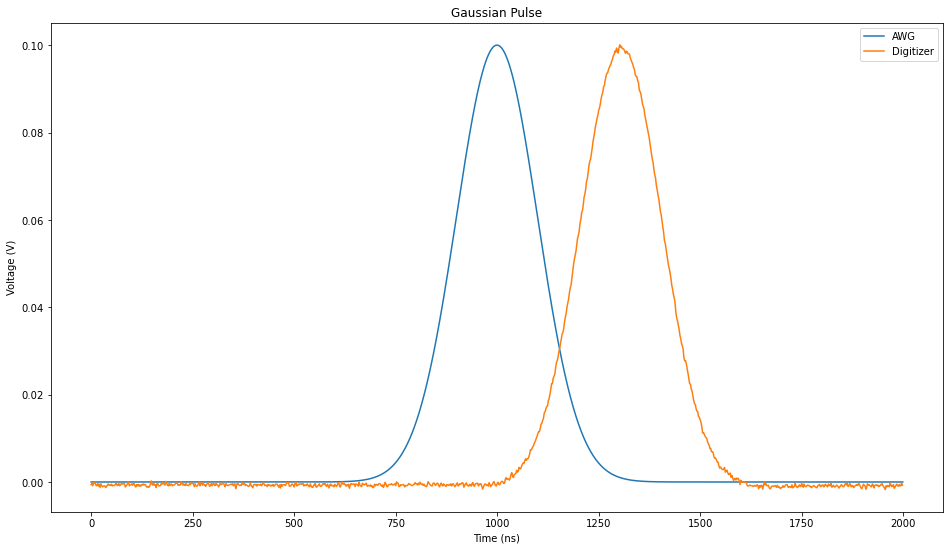

In [27]:
fig, ax = plt.subplots(figsize=(16, 9))

# Prepare wave data
duration_ns = 2000
gauss_pulse = AWGWaveData(awg_create_gaussian(a = 0.1, b = 0, c = 100, duration_ns = duration_ns))
gauss_pulse.plot(ax=ax)

# Configure AWG
awg_channel = 4
awg_reset(awg, awg_channel)
awg_set_output_awg(awg, awg_channel)
awg_load_and_start(awg, awg_channel, [AWGQueuedWave(gauss_pulse)])

# Configure Digitizer
full_scale = 0.2
dig_configure(dig, 1, duration_ns, full_scale)

# Send trigger
pxi_trigger_fall(awg)

# Capture and plot measured result
(time_ns, volts) = dig_retrieve_data(dig, 1, full_scale)
ax.plot(time_ns, volts, label="Digitizer")

# Tidy up plot
ax.set_title("Gaussian Pulse")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Voltage (V)")
ax.legend()

## Demo #2: Basic Square Pulse

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))

# Prepare wave data
duration_ns = 2000
square_pulse = AWGWaveData(awg_create_square_pulse(width_ns = 500, height = 0.1, duration_ns = duration_ns))
square_pulse.plot(ax=ax)

# Configure AWG
awg_channel = 4
awg_reset(awg, awg_channel)
awg_set_output_awg(awg, awg_channel)
awg_load_and_start(awg, awg_channel, [AWGQueuedWave(square_pulse)])

awg_channel = 1
awg_reset(awg, awg_channel)
# awg_set_output_fg(awg, awg_channel, frequency, amplitude = 0.0, shape = keysightSD1.SD_Waveshapes.AOU_SINUSOIDAL)
# awg_configure_am(awg, awg_channel)
awg_set_output_awg(awg, awg_channel)
awg_load_and_start(awg, awg_channel, [AWGQueuedWave(square_pulse)])

# Configure Digitizer
full_scale = 0.2
dig_configure(dig, 1, duration_ns, full_scale)

# Send trigger
pxi_trigger_fall(awg)

# Capture and plot measured result
(time_ns, volts) = dig_retrieve_data(dig, 1, full_scale)
ax.plot(time_ns, volts, label="Digitizer")

# Tidy up plot
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Voltage (V)")
ax.legend()

## Demo #3: Amplitude Modulation

In [70]:
fig, ax = plt.subplots(figsize=(16, 9))

# Prepare wave data
duration_ns = 5000
gauss_pulse = AWGWaveData(awg_create_gaussian(a = 0.2, b = 0, c = 500, duration_ns = duration_ns))
# gauss_pulse.plot(ax=ax)

# Configure AWG
frequency = 10e6

awg_channel = 4
awg_reset(awg, awg_channel)
awg_set_output_fg(awg, awg_channel, frequency, amplitude = 0.0, shape = keysightSD1.SD_Waveshapes.AOU_SINUSOIDAL)
awg_configure_am(awg, awg_channel)
awg_load_and_start(awg, awg_channel, [AWGQueuedWave(gauss_pulse)])

awg_channel = 1
awg_reset(awg, awg_channel)
awg_set_output_fg(awg, awg_channel, frequency, amplitude = 0.0, shape = keysightSD1.SD_Waveshapes.AOU_SINUSOIDAL)
awg_configure_am(awg, awg_channel)
awg_load_and_start(awg, awg_channel, [AWGQueuedWave(gauss_pulse)])

# Configure Digitizer
dig_channel = 1
full_scale = 1.0
dig_configure(dig, dig_channel, duration_ns, full_scale)

# Send trigger
pxi_trigger_fall(awg)

# Capture and plot measured result
(time_ns, volts) = dig_retrieve_data(dig, dig_channel, full_scale)
ax.plot(time_ns, volts * 1000, label="Measured by Digitizer")

p2p = (np.max(volts) - np.min(volts))
print(f"Peak-to-Peak: {p2p * 1000} mV")

# Tidy up plot
ax.set_title(f"{int(frequency / 1e6):d} MHz Carrier Modulated by Gaussian Pulse")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Voltage (mV)")
ax.legend()

Peak-to-Peak: 805.7191686758018 mV
